In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from keras.models import Model

Using TensorFlow backend.


In [2]:
#image directories
train_dir = "C:/Users/User/Desktop/NTU Projects/Intel Image Classification/Intel Images/seg_train/seg_train"
valid_dir = "C:/Users/User/Desktop/NTU Projects/Intel Image Classification/Intel Images/seg_test/seg_test"
pred_dir = "C:/Users/User/Desktop/NTU Projects/Intel Image Classification/Intel Images/seg_pred"

In [3]:
batch_num = 32
dim = 224
#create augementation for training
train_IDG = ImageDataGenerator(rescale = 1.0/255.0,
                              shear_range = 0.3,
                              zoom_range = 0.3,
                              horizontal_flip = True)
#training generator
train_gtr = train_IDG.flow_from_directory(directory = train_dir,
                                         target_size = (dim, dim),
                                         color_mode = 'rgb',
                                         batch_size = batch_num,
                                         class_mode = 'categorical',
                                         shuffle = True)

#create augmentation for validation 
valid_IDG = ImageDataGenerator(rescale = 1.0/255.0)
#validation generator
valid_gtr = valid_IDG.flow_from_directory(directory = valid_dir,
                                          target_size = (dim, dim),
                                          color_mode = 'rgb',
                                          batch_size = batch_num,
                                          class_mode = 'categorical',
                                          shuffle = True)

#create augmentation and generator for prediction
test_IDG = ImageDataGenerator(rescale = 1.0/255.0)
test_gtr = test_IDG.flow_from_directory(directory = pred_dir,
                                        target_size = (dim, dim),
                                        color_mode = 'rgb',
                                        batch_size = 1,
                                        class_mode = None,
                                        shuffle = True)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 1 classes.


## Building the VGG16 model - fine-tuned

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
v_model = VGG16(weights = 'imagenet')

In [ ]:
v_model.summary()

In [ ]:
#creating our own model with vgg16 architecture
model = Sequential()
for layer in v_model.layers:
    model.add(layer)

In [ ]:
model.summary()

In [ ]:
#remove the last 2 layers to add Dropouts
model.pop()
model.pop()
model.add(Dropout(0.4))
model.add(Dense(units = 4096, activation = "relu"))
model.add(Dropout(0.4))

In [ ]:
model.summary()

In [ ]:
#unfreezing conv blocks 4 and 5 for training
set_trainable = False
for layer in model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else: 
        layer.trainable = False

In [ ]:
#add our own final dense layer
model.add(Dense(6))
model.add(Activation('softmax'))
model.summary()

## Training

In [ ]:
#compile model
model.compile(optimizer = SGD(lr = 0.001), loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

In [ ]:
#fit data into model
with tf.device("GPU:0"):
    history = model.fit(train_gtr,
                       steps_per_epoch = 14034//batch_num,
                       epochs = 10,
                       validation_data = valid_gtr,
                       validation_steps = 3000//batch_num,
                       verbose = 1)

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
print('Training Accuracy: {:.3f}'.format(np.max(acc)))
print('Training Loss: {:.3f}'.format(np.max(loss)))
print('Validation Accuracy: {:.3f}'.format(np.max(val_acc)))
print('Validation Loss: {:.3f}'.format(np.max(val_loss)))
axes[0].plot(acc, label='Train')
axes[0].plot(val_acc, label='Validation')
axes[0].set_title('Model accuracy')
axes[0].set(ylabel = 'Accuracy', xlabel = 'Epoch')
axes[0].legend()
axes[1].plot(loss, label='Train')
axes[1].plot(val_loss, label='Validation')
axes[1].set_title('Validation loss')
axes[1].set(ylabel = 'Loss', xlabel = 'Epoch')
axes[1].legend()
plt.show()

In [ ]:
model.save('VGG16_Transfer Learning.model')

## Conclusion:
This shows the benefit of transfer learing. With VGG16's architecture, we were able to improve from just 63.2% accuracy (model built from scratch) to 92.5%. Furthermore, the 'Model loss' graph shows that the validation loss does not diverage far from the training loss, hence indicating absence of overfitting. This indicates that this model will perform well when exposed to new, unseen test images. 

## Predicting

In [4]:
#load model
model = tf.keras.models.load_model("VGG16_Transfer Learning.model")

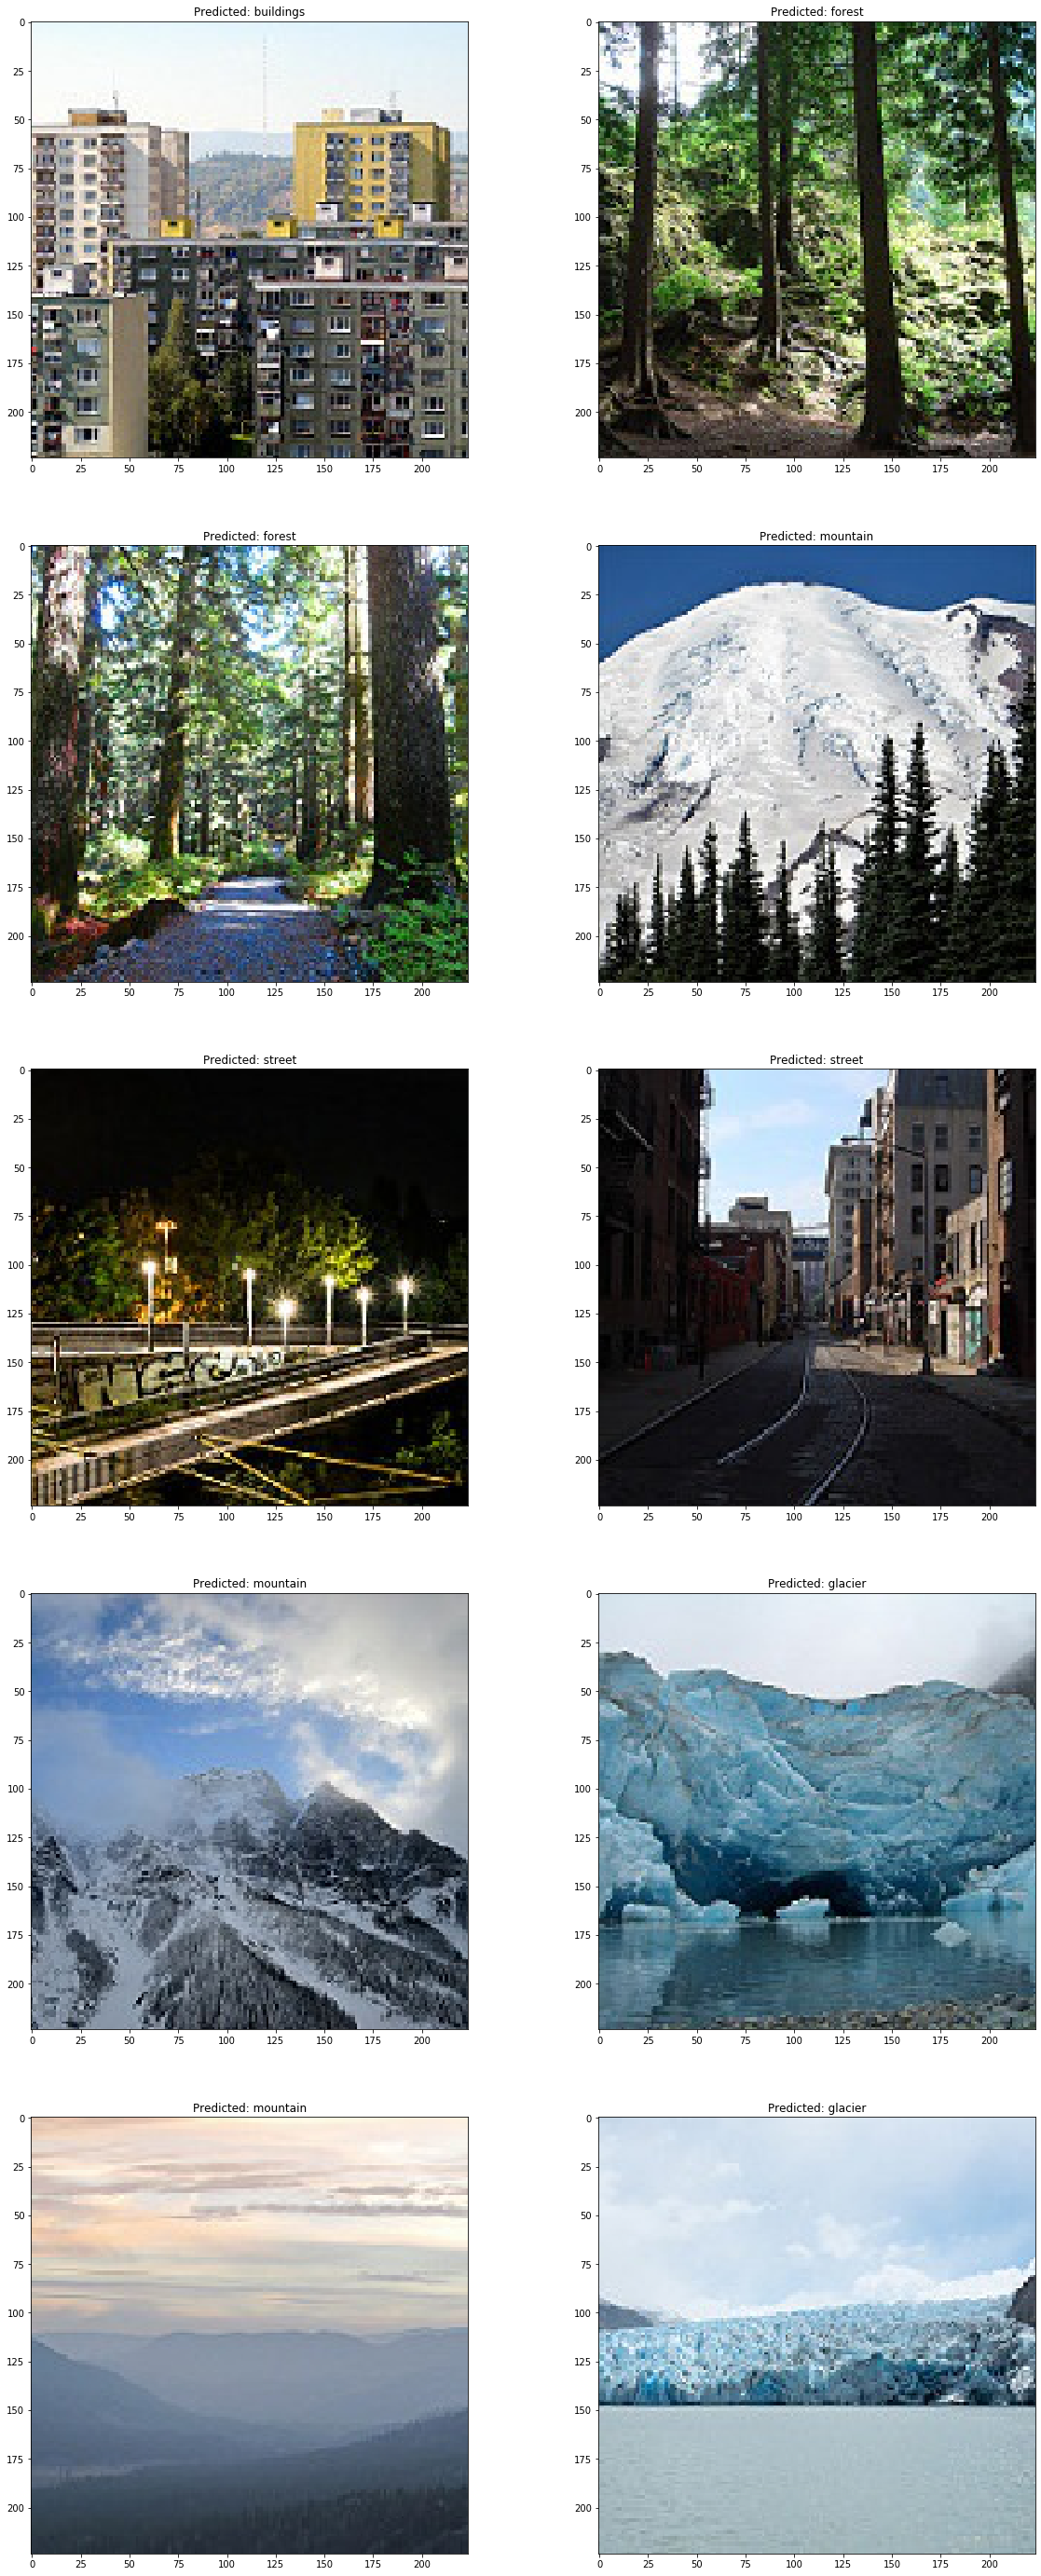

In [36]:
#predict first 10 pictures
result = []
images = []
cat = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
for i in range (10,20):
    test_img = np.asarray(test_gtr[i])
    images.append(test_img[0])
    pred = model.predict(test_img)
    max_ind = np.argmax(pred)
    result.append(cat[max_ind])
    
f,ax = plt.subplots(5,2, figsize = (20,50))
ax[0,0].set_title("Predicted: " + str(result[0]))
ax[0,0].imshow(images[0])
ax[0,1].set_title("Predicted: " + str(result[1]))
ax[0,1].imshow(images[1])
ax[1,0].set_title("Predicted: " + str(result[2]))
ax[1,0].imshow(images[2])
ax[1,1].set_title("Predicted: " + str(result[3]))
ax[1,1].imshow(images[3])
ax[2,0].set_title("Predicted: " + str(result[4]))
ax[2,0].imshow(images[4])
ax[2,1].set_title("Predicted: " + str(result[5]))
ax[2,1].imshow(images[5])
ax[3,0].set_title("Predicted: " + str(result[6]))
ax[3,0].imshow(images[6])
ax[3,1].set_title("Predicted: " + str(result[7]))
ax[3,1].imshow(images[7])
ax[4,0].set_title("Predicted: " + str(result[8]))
ax[4,0].imshow(images[8])
ax[4,1].set_title("Predicted: " + str(result[9]))
ax[4,1].imshow(images[9])